# A SARSA algorithm for PymGrid

Don't forget to add your own path in sys

In [1]:
import sys
sys.path.append('C:/Users/Tanguy LEVENT/Documents/Ploutos/Projet_Ploutos/ploutos/')
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np

### Generate One Microgrid

In [2]:
path = sys.path[len(sys.path)-1]
env = mg.MicrogridGenerator(path =path,nb_microgrid=1)
env.generate_microgrid(verbose = True)

,load,cost_loss_load,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_power_import,grid_power_export,grid_price_import,grid_price_export
0,7299388,10000,7372381.9,0.2,625,625,2500,0.9,0.2,1,0.3,2836,2836,0.3,0


Now I print the architecture of the random generated microgrid. I understand that I have an on-grid microgrid with battery

In [3]:
for i in range(env.nb_microgrids):
    
    print("Microgrid {} architecture: {}".format(int(i), str(env.microgrids[i].architecture)))

Microgrid 0 architecture: {'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}


I decide to plot my grid status in order to see if sometime the grid can be disconnected to the grid. Here we observe that the microgrid is always connected to the utility grid

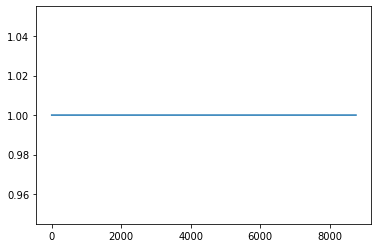

In [4]:
plt.plot(env.microgrids[0].grid_status)

Now I decide to call get_infos() method to print all the informations at once 

In [5]:
env.microgrids[0].get_info()

Microgrid parameters


,load,cost_loss_load,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_power_import,grid_power_export,grid_price_import,grid_price_export
0,7299388,10000,7372381.9,0.2,625,625,2500,0.9,0.2,1,0.3,2836,2836,0.3,0


Architecture:
{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}
Actions: 
Index(['pv_consummed', 'pv_curtailed', 'battery_charge', 'battery_discharge',
       'grid_import', 'grid_export'],
      dtype='object')
Status: 
Index(['net_load', 'battery_soc', 'capa_to_charge', 'capa_to_discharge'], dtype='object')
Has run mpc baseline:
False
Has run rule based baseline:
False


In [6]:
print("Penetration PV :", round(7372381.9/7299388*100,2), "%")

Penetration PV : 101.0 %


But I can do it seperatly with:

In [7]:
env.microgrids[0].df_actions

,pv_consummed,pv_curtailed,battery_charge,battery_discharge,grid_import,grid_export


In [8]:
env.microgrids[0].df_status

,net_load,battery_soc,capa_to_charge,capa_to_discharge
0,618.3,0.2,2222.2,0.0


In [9]:
env.microgrids[0].get_state()

{'state':    net_load  battery_soc  capa_to_charge  capa_to_discharge
 0     618.3          0.2          2222.2                0.0,
 'pv':            Data
 1      0.000000
 2      0.000000
 3      0.000000
 4      0.000000
 5      0.000000
 6      0.000000
 7      0.000000
 8    814.548416
 9   1772.840669
 10  3018.620599
 11  2683.218310
 12  3545.681338
 13  2299.901409
 14  1916.584507
 15  1868.669895
 16   766.633803
 17     0.000000
 18     0.000000
 19     0.000000
 20     0.000000
 21     0.000000
 22     0.000000
 23     0.000000
 24     0.000000,
 'load':            Load
 1    412.541149
 2    347.120491
 3    281.913817
 4    281.913817
 5    296.250726
 6    447.906821
 7    447.906821
 8   1108.824703
 9   1125.768322
 10  1125.768322
 11   844.282472
 12   826.132763
 13   826.132763
 14   888.888350
 15   875.718625
 16   875.718625
 17   855.662515
 18   960.786878
 19   960.786878
 20  1268.767803
 21  1371.596704
 22  1371.596704
 23   891.261624
 24   618.315670,
 '

Plot PV and Load for the next 24 hours

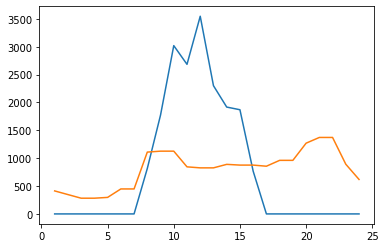

In [10]:
plt.plot(env.microgrids[0].get_state()['pv'])
plt.plot(env.microgrids[0].get_state()['load'])


Plot for 4 days

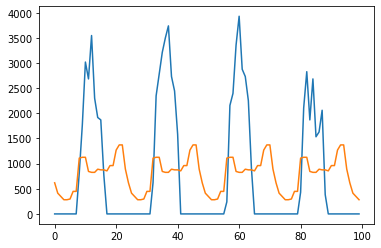

In [11]:
plt.plot(env.microgrids[0].pv.iloc[:100])
plt.plot(env.microgrids[0].load.iloc[:100])

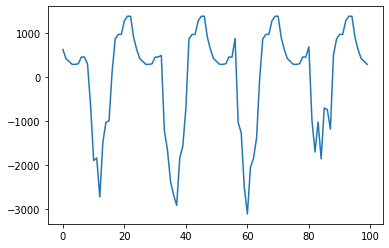

In [44]:
net_load = env.microgrids[0].load.values - env.microgrids[0].pv.values
plt.plot(net_load[:100])

### Design of the agent

First we need to define the different actions our agent will have to take in the microgrid environment. As a result we create a function actions_agent(). The run() fonction is similar to step() of OpenAI Gym, nevertheless run() take a dictionary as an input. So we need to return a dictionary of actions related to df_actions. We don't have to interact with pv_consummed and pv_curtailed because they follow the dynamic of the model. So sake of simplicity we consider that the agent can take only one of the 4 actions defined at the full rate of the net_load.

In [12]:
env.microgrids[0].df_actions

,pv_consummed,pv_curtailed,battery_charge,battery_discharge,grid_import,grid_export


In [13]:
env.microgrids[0].get_state()['state']

,net_load,battery_soc,capa_to_charge,capa_to_discharge
0,618.3,0.2,2222.2,0.0


In [14]:
def actions_agent(action, load, pv, status, parameters):
    
    #action 1: genset
    #action 1: battery_charge
    #action 2: battery_discharge
    #action 3: grid_import
    #action 4: grid_export
    
    control_dict= []
    
    nb_action = 4
    
    capa_to_charge = max(
                        (parameters['battery_soc_max'].values[0] * parameters['battery_capacity'].values[0] -
                         status['battery_soc'] *
                         parameters['battery_capacity'].values[0]
                         ) *parameters['battery_efficiency'].values[0], 0)
    capa_to_discharge = max((status['battery_soc'] *
                                             parameters['battery_capacity'].values[0]
                                             - parameters['battery_soc_min'].values[0] *
                                             parameters['battery_capacity'].values[0]
                                             ) * parameters['battery_efficiency'].values[0], 0)
    # state 0 genset covers what needs to be covered
    if action == 0:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': 0,
                            'genset': max(0, load-pv),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load-pv, 0)}
    
    # state 1 to charge the battery in case of excess PV    
    elif action ==1:
        control_dict = {'battery_charge': max(0, min(capa_to_charge, parameters['battery_power_charge'].values[0],
                                             pv-load)),
                            'battery_discharge': 0,
                            'genset': max(0, load-pv),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load- max(0, min(capa_to_charge, parameters['battery_power_charge'].values[0],
                                             pv-load))-pv, 0)}
        
    # state 2 discharge the battery, cover the rest with genset
    elif action ==2:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': max(0, min(capa_to_discharge, parameters['battery_power_discharge'].values[0],
                                                load-pv)),
                            'genset': max(0, load-pv-max(0, min(capa_to_discharge, parameters['battery_power_discharge'].values[0],
                                                load-pv))),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load-pv, 0)}
        
    # do not cover the load 
    elif action == 3:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': 0,
                            'genset': 0,
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': load,
                            'pv_consummed': 0,
                            'pv_curtailed':pv}
        
    
    return control_dict, nb_action
    

Now I create functions for the SARSA agent.
The first one is to initialize my Q table. I need to round the state to reduce the state space.

In [48]:
def init_qtable(init_way, nb_action,env):
    
    net_load = env.microgrids[0].load.values - env.microgrids[0].pv.values
    
    min_state_value = int(round(abs(net_load.min())))
    max_state_value = int(round(net_load.max().values[0]))
    nb_state = max_state_value + min_state_value
    
    if init_way == "ones":
        
        Q =  np.ones((nb_state, nb_action))
        
    elif init_way == "random":
        
        Q = np.random.random((nb_state, nb_action))
        
    elif init_way == "zeros":
        
        Q = np.zeros((nb_state, nb_action))
        
    return Q    

I define a function for my exploration strategy. Here I've selected the epsilon greedy decreasing strategy

In [16]:
def espilon_decreasing_greedy(action, epsilon, nb_action):
    
    p = np.random.random()

    if p < (1 - epsilon):

        return action

    else: 

        return np.random.choice(nb_action)

I also need to define a function to decrease and update my espilon 

In [17]:
def update_epsilon(epsilon):
    
    epsilon = epsilon - epsilon *0.02
    
    return epsilon

Now I define my agent function

In [ ]:
def sarsa_agent(nb_it, Q, env):
    
    total_reward = 0
    env.microgrids[0].reset()
    s = env.microgrids[0].get_state()['state']['net_load'].values[0]
    a = np.argmax(Q[s, :])
    a = espilon_decreasing_greedy(a, epsilon, nb_action)
    a = actions_agent()
    while not env.microgrids[0].done:
        
        all_state = run()
    

In [54]:
 env.microgrids[0].get_state()

{'state':    net_load  battery_soc  capa_to_charge  capa_to_discharge
 0     618.3          0.2          2222.2                0.0,
 'pv':            Data
 1      0.000000
 2      0.000000
 3      0.000000
 4      0.000000
 5      0.000000
 6      0.000000
 7      0.000000
 8    814.548416
 9   1772.840669
 10  3018.620599
 11  2683.218310
 12  3545.681338
 13  2299.901409
 14  1916.584507
 15  1868.669895
 16   766.633803
 17     0.000000
 18     0.000000
 19     0.000000
 20     0.000000
 21     0.000000
 22     0.000000
 23     0.000000
 24     0.000000,
 'load':            Load
 1    412.541149
 2    347.120491
 3    281.913817
 4    281.913817
 5    296.250726
 6    447.906821
 7    447.906821
 8   1108.824703
 9   1125.768322
 10  1125.768322
 11   844.282472
 12   826.132763
 13   826.132763
 14   888.888350
 15   875.718625
 16   875.718625
 17   855.662515
 18   960.786878
 19   960.786878
 20  1268.767803
 21  1371.596704
 22  1371.596704
 23   891.261624
 24   618.315670,
 '

In [51]:
env.microgrids[0].get_state()['state']['net_load'].values[0]

618.3

In [56]:
env.microgrids[0].reset()

In [55]:
env.microgrids[0].parameters

,load,cost_loss_load,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_power_import,grid_power_export,grid_price_import,grid_price_export
0,7299388,10000,7372381.9,0.2,625,625,2500,0.9,0.2,1,0.3,2836,2836,0.3,0
